In [1]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [2]:
%reload_ext autoreload
%autoreload 2

# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW11


---
__Name:__  Megan Jasek   
__Class:__ MIDS w261 - Summer 2016 - Group 2  
__Email:__  meganjasek@iSchool.Berkeley.edu     
__Week:__   11

# Table of Contents <a name="TOC"></a> 

1.  [HW Intructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    HW11.0.  [Broadcast versus Caching in Spark ](#HW11.0)    
    HW11.1.  [HW11.2 Gradient descent](#HW11.1)   
    HW11.2.  [Gradient descent](#HW11.2)    
    HW11.3.  [Logistic Regression](#HW11.3)    
    HW11.4.  [SVMs](#HW11.4)  
    HW11.5.  [OPTIONAL  Distributed Perceptron algorithm](#HW11.5)  
    HW11.6.  [OPTIONAL  Evalution of perceptron algorihtms on PennTreeBank POS corpus](#HW11.6)  
    HW11.7.  [OPTIONAL Kernal Adatron](#HW11.7)
   
    HW11.8.  [OPTIONAL Create an animation of gradient descent for the Perceptron](#HW11.8)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale
DATSCIW261 ASSIGNMENT #11

Version 2016-07-27 (FINAL)


 === INSTRUCTIONS for SUBMISSIONS ===
Follow the instructions for submissions carefully.

https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 


=== IMPORTANT ===

TYPE-2 Fun option: Submit HW11 using a Zeppelin notebook (See Live slides for install instructions)

TYPE-1.5 Fun option: Complete HW11.8 only (no need to complete the rest of the questions)

HW11 can be completed locally on your computer
### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. (Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))

<a name="3">
# HW Problems
[Back to Table of Contents](#TOC)

### Create a Spark Context to use throughout this homework

In [3]:
import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "HW11"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc.stop()
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)

print sc
print sqlContext

<a name="HW11.0"></a><h2 style="color:darkblue"> HW11.0: Broadcast versus Caching in Spark </h2>
[Back to Table of Contents](#TOC)

Q: What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer.

**ANSWER:**  
In Spark, broadcasting refers to the process of caching a value in memory on each of the nodes.  When an action is performed on an RDD in Spark, a closure is shipped to all of the executors (all of the nodes that will be executing the action).  The closure includes the code for the action plus the value of all variables used in the code at the time of shipment.  The entire closure is shipped once for each chunk of data that a node is processing.  For big data, the number of chunks processed on each node could be very large.  The size of the code is usually small, but the size of the data in the variables could be large.  Shipping these variable values for each chunk of code can cause unnecessary use of constrained network resources.  Since these variable values will not change for each of the chunks of code, they can safely be sent to each executor one time before any data is processed.  This is a case when broadcast variables in Spark can be used.  Spark uses efficient communication processes to send the variable values one time to each executor to be used for all of the data chunks sent to that executor.  An example of this is the KMeans algorithm that has been studied in this class.  For each iteration of the algorithm a set of cluster centroids needs to be sent to each node.  A broadcast variable can be used to send the cluster centroids to each node.    Broadcasting is useful for information that changes every iteration.

In Spark, caching data or using the .cache() action refers to storing an RDD in memory for later use.  If an RDD will be used over and over again, then it might save time to store it in memory with the .cache() action.  Since Spark uses lazy evaluation with transformations (i.e. the RDD is not transformed until an action is called and then all of the transformations are performed in memory) then in order to get a transformed RDD into memory all of the transformations that create it need to be performed each time in order to access it.  Using the .cache() method a transformed RDD can be stored in memory for later use.  One example where this is useful in machine learning is storing the training data while training a machine learning algorithm.  The training data will not change during the entire training process, so it can be cached in memory before training starts and can be accessed repeatedly during the training process.

Q: Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes.

Notebook
https://www.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb?dl=0

Notebook via NBViewer
http://nbviewer.ipython.org/urls/dl.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb

**ANSWER:**  
The code below is updated to use the broadcast pattern to make the implementation more efficient.  The variable <code>centriods</code> stores the cluster centroids for each iteration.  The new values for the centroids need to be sent to each node after each iteration.  This variable can be made a broadcast variable.  In order make <code>centriods</code> a broadcast variable, use the <code>sc.broadcast()</code> command in Spark as is done below.  To access the value in the broadcast variable use <code>centriods.value</code>.  In the code below, all previous now unused code is labeld with '#OLD' and all new updated code is labeled with '#NEW' at the end of the line.

```python
import numpy as np
#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    ##### Access the broadcasted variable's value with centroids.value #####
    #closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()        #OLD
    closest_centroid_idx = np.sum((x - centroids.value)**2, axis=1).argmin()   #NEW
    return (closest_centroid_idx,(x,1))
K = 3
#Initialization: initialization of parameter is fixed to show an example
##### Make the centroids variable a broadcast variable using sc.broadcast() #####
#centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])                #OLD
centroids = sc.broadcast(np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]]))   #NEW
D = sc.textFile("./data.csv").cache()
iter_num = 0
for i in range(10):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    ##### Access the broadcasted variable's value with centroids.value #####
    #if np.sum(np.absolute(centroids_new-centroids))<0.01:        #OLD
    if np.sum(np.absolute(centroids_new-centroids.value))<0.01:   #NEW
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    ##### Make the centroids variable a broadcast variable using sc.broadcast() #####
    #centroids = centroids_new                #OLD
    centroids = sc.broadcast(centroids_new)   #NEW
```

<a name="HW11.1"> <h2 style="color:darkgreen">HW11.1 Loss Functions</h2>
[Back to Table of Contents](#TOC)
 
In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as an L2 penalized logistic regesssion learning algorithm? 

In your reponse, please discuss the loss functions, the learnt models and the separating surfaces between the two classes.  
**ANSWER:**  
No, the linear SVM learning algorithm does not yield the same result as an L2 penalized logitistic regression learning algorithm.

The loss function for an SVM is the hingle loss function.  With L2 regularization (default regularization for SVM learning algorithms), the loss function is as follows:
$$J(w) = \sum_i max(0, 1- y^iw^Tx^i) + \frac{1}{2}|| w ||^2$$

Whereas the loss function for logistic regression with L2 regularization is different and is as follows:
$$J(w) = \sum_i y^i \log g_w(x^{(i)}) + (1-y^i)(\log 1 - g(x^{(i)})) + \lambda || w ||^2, y^i \in (0,1)$$

Both of the learnt models for the algorithms are a set of weights, $w$.

This set of weights, $w$ (which is different for each algorithm) will produce different separating surfaces (or hyperplanes) for each of the algorithms.  The set of possible hyperplanes that can be produced for the SVM algorithm is less constrained (larger) than the set of possible hyperplanes (smaller) that can be produced for the logistic regression algorithm.  This can be seen by the graph in Figure 1 below.  The loss function for SVM's (hinge loss) is shown in green and the loss function for logistic regression (log loss) is shown in orange.  The loss function for SVM's gets to 0 sooner than the loss function for logistic regression as that loss function is more constrained.  That algorithm will keep working to find a resulting weight vector that optimizes the weights where as the SVM algorithm will stop when the margin (margin = $m^i(w) = y^iw^Tx^i$) gets to 1.  

In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a perceptron learning algorithm?  
**ANSWER:**  
No, the linear SVM learning algorithm does not yield the same result as a perceptron learning algorithm.  The loss function for the perceptron learning algorithm is as follows:
$$J(w) = \sum_i max(0, - y^iw^Tx^i)$$

Following the same reasoning as above, the perceptron learning algorithm is less discriminating than the SVM algorithm.  As seen in Figure 1 below, the perceptron loss function reaches 0 before the SVM loss function.  The perceptron algorithm will keep working to find a solution until the margin (margin = $m^i(w) = y^iw^Tx^i$) gets to 0, while the SVM algorithm will keep working until the margin is 1.

[OPTIONAL]: generate an artifical binary classification dataset with 2 input features and plot the learnt separating surface for both a linear SVM and for  logistic regression. Comment on the learnt surfaces. Please feel free to do this in Python (no need to use Spark).

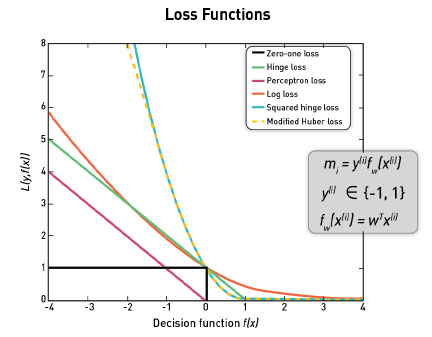

In [1]:
##### Figure 1:  Loss Functions Graph #####
from IPython.display import Image
Image(filename="LossFunctionGraph.jpg")

<a name="HW11.2"><h2 style="color:darkgreen">HW11.2 Gradient descent</h2>
[Back to Table of Contents](#TOC)

In the context of logistic regression describe and define three flavors of penalized loss functions.  Are these all supported in Spark MLLib (include online references to support your answers)?  
**ANSWER:**  

A penalized loss function consists of a **loss term** (which is expressed in terms of the margin of each training example) and a **regularization term** (which is expressed as a function of model complexity).

For logistic regression the **loss term** is as follows:  
$$J(w) = \sum_i y^i \log g_w(x^{(i)}) + (1-y^i)(\log 1 - g(x^{(i)})) + \lambda || w ||^2, y^i \in (0,1)$$

For logistic regression, 3 types of **regularization terms** are None, Lasso and Ridge.  
* **None:**  there is no regularization term and only the loss term is used.  
* **Lasso (L1):**  the regularization term is the absolute value of the weight vector, $|w|$.  This type of regularization helps prevent overfitting by eliminating features that do not contribute to the model.
* **Ridge (L2):**  the regularization term is the square of the weight vector, $w^2$.  This type of regularization helps prevent overfitting by weighing some features as more important than others.

Yes, all of these penalized loss functions are supported in Spark LLLib.  Documentation can be found in this link: https://spark.apache.org/docs/1.6.0/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithLBFGS, the logisitc regression function takes an argument called 'regType' which is the type of regularizer used for training the model.  The allowed values are as follows:  
<code>“l1”</code> for using L1 regularization  
<code>“l2”</code> for using L2 regularization  
<code>None</code> for no regularization  
(default: <code>“l2”</code>)  

Descibe probabilitic interpretations of the L1 and L2 priors for penalized logistic regression (HINT: see synchronous slides for week 11 for details).  
**ANSWER:**  

L1 priors are distributed using a LaPlace distribution.

L2 priors are distributed using a Guassian distribution.

<a name="HW11.3"> <h2 style="color:darkblue"> HW11.3 Logistic Regression</h2>
[Back to Table of Contents](#TOC)

Working from the following notebook as a starting point complete HW11.3:

   + http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/fwrkxh88xblp5c7/LogisticRegression-Notebook-Challenge.ipynb

Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.

```python
def generateData(n):
""" 
  generates a 2D linearly separable dataset with n samples. 
  The third element of the sample is the label
"""
xb = (rand(n)*2-1)/2-0.5
yb = (rand(n)*2-1)/2+0.5
xr = (rand(n)*2-1)/2+0.5
yr = (rand(n)*2-1)/2-0.5
inputs = []
for i in range(len(xb)):
  inputs.append([xb[i],yb[i],1])
  inputs.append([xr[i],yr[i],-1])
return inputs

```
Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. 

NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.

Using MLLib train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the logistic regression model? Justify with plots and words.  
**ANSWER:**  
With an initial weight vector of <code>w = [1, 1, 0]</code>, a good number of iterations to train the model using the training data is 10.  At iterations 10, 11 and 12 the model weights are exactly the same:  
Iteration 9: Model Weights:  [-1.3607545186188592, 0.81160204598364283, -0.002205141336945677]  
Iteration 10: Model Weights:  [-1.3608070625795736, 0.81099644153545281, -0.002162380389093979]  
Iteration 11: Model Weights:  [-1.360807062579573, 0.81099644153545392, -0.0021623803890939907]  
Iteration 12: Model Weights:  [-1.3608070625795747, 0.81099644153545181, -0.00216238038909398]  
This can also be seen by the plots in the section labeled, 'PLOTS FOR HW11.3 MLLIB LASSO LOGISTIC REGRESSION'.  After about 10 iterations, the plot of the hyperplane is no longer changing.  The number of iterations will change based in the initial weight vector.  If an initial weight vector is closer to the actual weight vector, then the number of iterations will be smaller and vice versa for an initial weight vector that is far from the actual weight vector. 

Derive and implement in Spark a weighted LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm. 

Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm): 

>weight(X)= 1/||X||, 

>where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

>Here X is vector made up of X1 and X2.

Evaluate your homegrown weighted LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations it took to converge.  
**ANSWER:**  
Misclassification rate is always 0.1 or 10% because that is how many data points were put on the opposite side of the hyperplane when generating the data.
With an initial weight vector of <code>w = [1, 1, 0]</code>, the algorithm converges 17 iterations of running the algorithm with 150 iterations, so that is 17 x 150 = 2,550 iterations total.  It stopped after getting a <code>True</code> value from the function <code>stopping_criteria_reached</code> which calculates the difference between the current weight vector and the new weight vector by summing the absolute value of the difference of each component of the two vectors.  A value of epsilon of 0.01 was used with the <code>stopping_criteria_reached</code> function which sets the value to <code>True</code> only when the difference between the vectors is less than epsilon.  The plots of the weight vectors for each run are displayed in the section labeled, 'PLOTS FOR HW11.3 HOMEGROWN LASSO LOGISTIC REGRESSION'.  

Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set.  
**ANSWER:**  
I was unable to find a weighted LASSO logistic regression implementation in Spark MLLib.

### HW11: Helper functions for 

In [4]:
%matplotlib inline
import pylab

# Plot data points but don't display them
def plot_data_no_show(samples, shape_str, color_str_pos, color_str_neg, title):
    for data in samples:
        color_str = color_str_pos
        if data[2] == -1:
            color_str = color_str_neg
        pylab.plot(data[0], data[1], shape_str, color = color_str)
    pylab.title(title)

# Plot data points and display them
def plot_data(samples, shape_str, color_str_pos, color_str_neg, title):
    plot_data_no_show(samples, shape_str, color_str_pos, color_str_neg, title)
    pylab.show()
    
# Set the color for positive and negative training examples
# Light brown and dark grey
color_str_pos = '#D4B996'
color_str_neg = '#4F4F4F'

### HW11.3:  Generate testing set and training set

In [5]:
import numpy as np

# Set a random seed so results are consistent across multiple runs
np.random.seed(114)

def generateData(n, filename):
    """
        generates a 2D linearly separable dataset with n samples. 
        The third element of the sample is the label
    """
    # Write the datapoints to filename.  Swap the position of the label to the 1st element
    # when writing to the file for later use.
    with open(filename, 'w') as f:
        xb = (np.random.rand(n)*2-1)/2-0.5
        yb = (np.random.rand(n)*2-1)/2+0.5
        xr = (np.random.rand(n)*2-1)/2+0.5
        yr = (np.random.rand(n)*2-1)/2-0.5
        inputs = []
        for i in range(len(xb)):
            inputs.append([xb[i],yb[i],1])
            inputs.append([xr[i],yr[i],-1])
            f.write('%f, %f, %f\n' % (1.0, xb[i], yb[i]))
            f.write('%f, %f, %f\n' % (-1.0, xr[i], yr[i]))
    return inputs

def generateNonSeperableData(n, filename):
    """
        generates a 2D linearly non-separable dataset with n samples. 
        The third element of the sample is the label
    """
    # Write the datapoints to filename.  Swap the position of the label to the 1st element
    # when writing to the file for later use.
    with open(filename, 'w') as f:
        xb = (np.random.rand(n)*2-1)/2-0.5
        yb = (np.random.rand(n)*2-1)/2+0.5
        xr = (np.random.rand(n)*2-1)/2+0.5
        yr = (np.random.rand(n)*2-1)/2-0.5
        inputs = []
        for i in range(len(xb)):
            # For 10% of the data points, swap the label from 1 to -1, so that they
            # end up on the other side of the decision boundary
            if i < n/10:
                inputs.append([xb[i],yb[i],-1])
                inputs.append([xr[i],yr[i],1]) 
                f.write('%f, %f, %f\n' % (-1.0, xb[i], yb[i]))
                f.write('%f, %f, %f\n' % (1.0, xr[i], yr[i]))
            else:
                inputs.append([xb[i],yb[i],1])
                inputs.append([xr[i],yr[i],-1])
                f.write('%f, %f, %f\n' % (1.0, xb[i], yb[i]))
                f.write('%f, %f, %f\n' % (-1.0, xr[i], yr[i]))
    return inputs

train_sep = generateData(100, 'train_sep.csv')
test_sep = generateData(100, 'test_sep.csv')

train_nonsep = generateNonSeperableData(100, 'train_nonsep.csv')
test_nonsep = generateNonSeperableData(100, 'test_nonsep.csv')

### Ensure saved data looks like data

In [6]:
#!head train_nonsep.csv
#print train_nonsep[0:10]
#!head test_nonsep.csv
#print test_nonsep[0:10]

### HW11.3:  Plot the seperable data

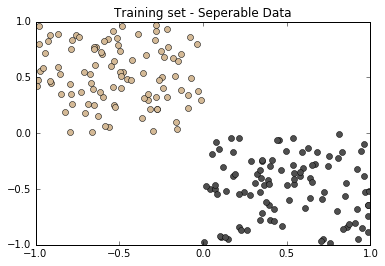

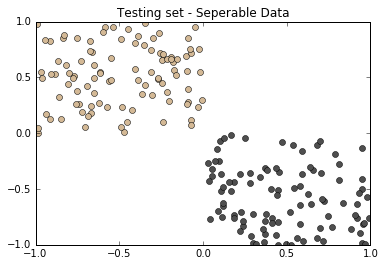

In [7]:
# Plot the data
plot_data(train_sep, 'o', color_str_pos, color_str_neg, 'Training set - Seperable Data')
plot_data(test_sep, 'o', color_str_pos, color_str_neg, 'Testing set - Seperable Data')

### HW11.3:  Plot the non-seperable data

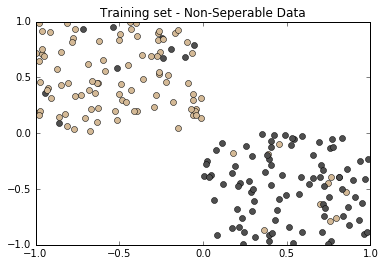

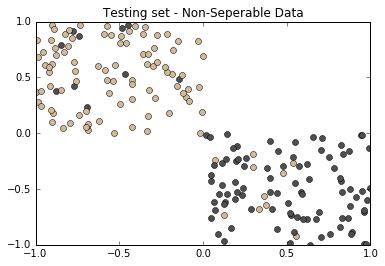

In [8]:
# Plot the data
plot_data(train_nonsep, 'o', color_str_pos, color_str_neg, 'Training set - Non-Seperable Data')
plot_data(test_nonsep, 'o', color_str_pos, color_str_neg, 'Testing set - Non-Seperable Data')

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# Formulat for plotting weights
# y = [-(i * w[0] + model.intercept) / w[1] for i in x]
# where intercept is either 0, or w[2] if there is a third element

def plot_weights_no_show(w, color_str, shape_str, num_iter=-1):
    x1 = [-1, 1]
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    if num_iter != -1:
        plt.plot(x1, x2, color_str+shape_str, label="After "+str(num_iter)+" Iterations", linewidth=2.0)
    else:
        plt.plot(x1, x2, linewidth=2.0)        


### HW11.3:  MLLib LASSO logistic regression model

Iteration  1
Testing Error = 0.215
Model Weights:  [0.32986182877800968, 2.243335631109729, 0.48323880281681153]
Iteration  2
Testing Error = 0.11
Model Weights:  [-1.8010964404549774, 1.8279066385147071, -0.44622147593863304]
Iteration  3
Testing Error = 0.105
Model Weights:  [-1.4332455577999985, 1.6701041756568453, -0.07480053474637005]
Iteration  4
Testing Error = 0.105
Model Weights:  [-1.2262363813366453, 1.5024615024358505, 0.06322199202205442]
Iteration  5
Testing Error = 0.1
Model Weights:  [-1.1011611105195149, 1.2704256762573154, 0.019658135520899567]
Iteration  6
Testing Error = 0.1
Model Weights:  [-1.0643525435358672, 1.0695261511564422, -0.007445381041520115]
Iteration  7
Testing Error = 0.1
Model Weights:  [-1.1156959606350656, 1.0261044521526472, -0.00909336358574612]
Iteration  8
Testing Error = 0.1
Model Weights:  [-1.3546785998453921, 0.80899661424081304, -0.0023859031871478788]
Iteration  9
Testing Error = 0.1
Model Weights:  [-1.3607545186188597, 0.811602045983642

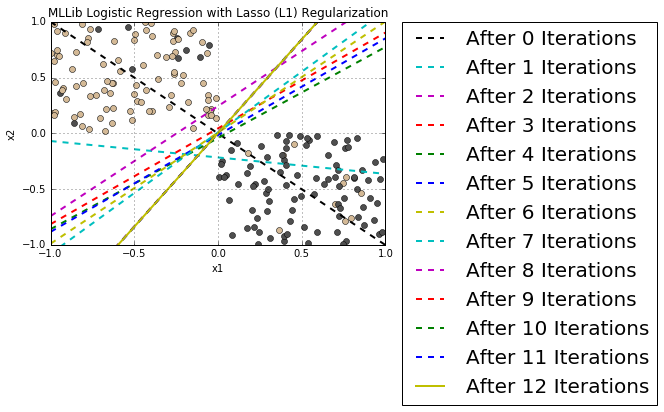

In [22]:
##### PLOTS FOR HW11.3 MLLIB LASSO LOGISTIC REGRESSION #####

%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionWithSGD, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint

# Parse the data
def parse_point(point):
    label = point[2]
    if label == -1:
        label = 0
    # A labeled point contains the label and an array of values as the features
    return LabeledPoint(label, point[0:2])

# Create RDDs for the training and testing data
train_data = sc.parallelize(train_nonsep).map(parse_point)
test_data = sc.parallelize(test_nonsep).map(parse_point)

# Plot the data points, but don't display them yet
plot_data_no_show(train_nonsep, 'o', color_str_pos, color_str_neg, '')

# Set the initial weights and plot them
initial_weights = [1,1]
plot_weights_no_show([initial_weights[0], initial_weights[1], 0.0], 'k', '--', 0)

# Set the iterations
iterations = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# Set the group of colors to be used
colors = ['c', 'm', 'r', 'g', 'b', 'y']
for i, num_iter in enumerate(iterations):
    print 'Iteration ', str(num_iter)
    # Build the model
    model = LogisticRegressionWithLBFGS.train(train_data, iterations=num_iter, initialWeights=initial_weights, regType='l1',
                                              regParam=0.1, intercept=True)

    # Evaluating the model on testing data
    labelsAndPreds = test_data.map(lambda p: (p.label, model.predict(p.features)))
    testErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(test_data.count())
    print("Testing Error = " + str(testErr))

    # Set the shape of the line to '--' unless it's the last iteration in which case set it to a solid line.
    shape = '--'
    if num_iter == iterations[-1]:
        shape = '-'
    plot_weights_no_show([model.weights[0], model.weights[1], model.intercept], colors[i%len(colors)],
                         shape, num_iter)
    print 'Model Weights: ', [model.weights[0], model.weights[1], model.intercept]

# Display the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title('MLLib Logistic Regression with Lasso (L1) Regularization')
plt.grid()
plt.show()

### HW11.3:  Homegrown LASSO logistic regression model

In [10]:
from collections import namedtuple
from math import sqrt
import numpy as np
Point = namedtuple('Point', 'x y')

# Function returns True if absolute value of the difference of the old_weights and 
# new_weights is less than epsilon.
def stop_criterion_reached(old_weights, new_weights, epsilon):
    Stop = False
    total_error = 0.0
    for pr1, pr2 in zip(old_weights, new_weights):
        total_error += abs(pr1-pr2)
    print 'Total Error: ', total_error
    if total_error < epsilon:
        Stop = True
    return Stop

# Return 1 if the prediction matches the true label for the data point.
# Return 0, otherwise.
def calculate_accuracy(d):
    prob = 1 / (1 + np.exp(-np.dot(w, d.x)))
    y_hat = 1.0 if prob >= 0.5 else -1.0
    correct = 1 if y_hat == d.y else 0
    return correct

# Create a Point from a line of data from a file.  If weighted = True, then weight each data
# point.
def readPoint(line, weighted=False):
    d = line.split(',')
    x = [float(i) for i in d[1:]]
    if weighted:
        weight = 1.0/sqrt(sum([i*i for i in x]))
        x = [i*weight for i in x]
    x.append(1.0)  #bias term
    return Point(x, float(d[0]))

# Function performs logistic regression
def logisticRegressionGDReg(data, wInitial=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None):
    featureLen = len(data.take(1)[0].x)
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda p: (1 / (1 + np.exp(-p.y*np.dot(wBroadcast.value, p.x)))-1) * p.y * np.array(p.x))\
                    .reduce(lambda a, b: a + b)
        if regType == "Ridge":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
        elif regType == "Lasso":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
            wReg = (wReg>0).astype(int) * 2-1
        else:
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        w = w - learningRate * gradient / n
    return w

Initial Weights:  [1 1 0]
Iteration  1
Total Error:  2.83048129001
Model Weights:  [-0.78117468  2.01652743 -0.03277919]
Misclassification after 1 iterations: 0.100000
Iteration  2
Total Error:  0.450431983792
Model Weights:  [-1.19499807  2.04738879 -0.02703196]
Misclassification after 2 iterations: 0.100000
Iteration  3
Total Error:  0.277900023166
Model Weights:  [-1.38458422  1.96608873 -0.02001815]
Misclassification after 3 iterations: 0.100000
Iteration  4
Total Error:  0.213690399242
Model Weights:  [-1.50061908  1.87476097 -0.01369037]
Misclassification after 4 iterations: 0.100000
Iteration  5
Total Error:  0.167118773049
Model Weights:  [-1.58315469  1.79545209 -0.00841609]
Misclassification after 5 iterations: 0.100000
Iteration  6
Total Error:  0.131120721663
Model Weights:  [-1.64600883  1.73143502 -0.00416658]
Misclassification after 6 iterations: 0.100000
Iteration  7
Total Error:  0.102893331841
Model Weights:  [ -1.69516999e+00   1.68107502e+00  -7.94414553e-04]
Miscla

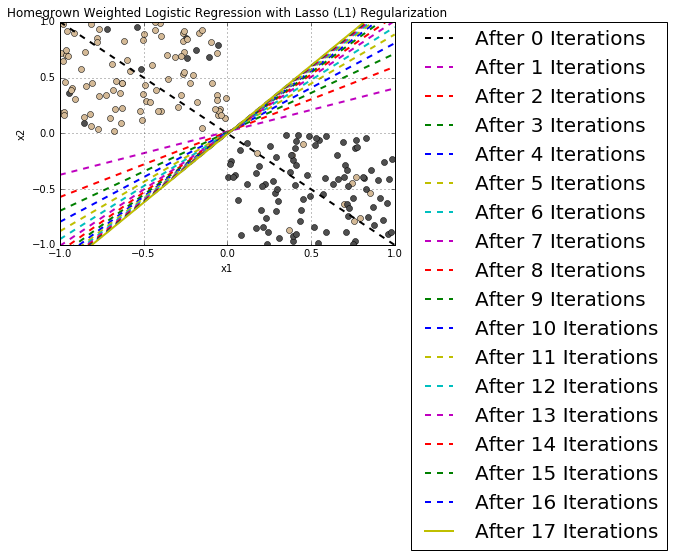

In [21]:
##### PLOTS FOR HW11.3 HOMEGROWN LASSO LOGISTIC REGRESSION #####

# Set a threshold for stopping criteria
epsilon = .01

# Plot the data points, but don't display them yet
plot_data_no_show(train_nonsep, 'o', color_str_pos, color_str_neg, '')

# Plot the initial weights
w = np.array([1, 1, 0])
#w = np.array([0, 0, 0])
print 'Initial Weights: ', w
plot_weights_no_show(w, 'k', '--', 0)

# Read the training data into Spark, weight it and cache it
data = sc.textFile('train_nonsep.csv').map(lambda x: readPoint(x, weighted=True)).cache()
n_train = data.count()

# Read the testing data into Spark, weight it and cache it
data_test = sc.textFile('test_nonsep.csv').map(lambda x: readPoint(x, weighted=True)).cache()
n_test = data_test.count()

# Set the colors to be used in the plots
colors = ['c', 'm', 'r', 'g', 'b', 'y']
i = 1
stop = False
while (stop == False):
    # Store the previous set of weights
    old_weights = w
    print 'Iteration ', str(i)
    # Run the logistic regression algorithm
    w = logisticRegressionGDReg(data, w, learningRate=0.1, iterations=150, regType='Lasso')
    # Test to see if the stopping criterion is reached
    stop = stop_criterion_reached(old_weights, w, epsilon)
    # Set the shape of the line for the plot.  Set it to '--' unless it's the last iteration in which case
    # set it to a solid line
    shape = '--'
    if stop == True:
        shape = '-'
    # Plot the weights of this iteration
    plot_weights_no_show(w, colors[i%len(colors)], shape, i)
    print 'Model Weights: ', w
    # Calculate the accuracy
    accuracy = data_test.map(calculate_accuracy).reduce(lambda a, b: a + b) / float(n_test)
    print 'Misclassification after %d iterations: %f' % (i, 1-accuracy)
    i += 1

# Display the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title('Homegrown Weighted Logistic Regression with Lasso (L1) Regularization')
plt.grid()
plt.show()

In [ ]:
#if you use `LogisticRegressionWithLBFGS`, you can set the optimizer's updater to `L1Updater`,
#which supports weights, and i think they get passed through if you call the variant of `run` with a weights arg

In [85]:
# Check to make sure that the weights are being calculated properly
#Initial Weights:  [1 1 0]
#-1.000000, -0.188855, 0.751381
#1.000000, 0.698844, -0.635319
#-1.000000, -0.107933, 0.680309
#[Point(x=[-0.188855, 0.751381, 1.0], y=-1.0), Point(x=[0.698844, -0.635319, 1.0], y=1.0), Point(x=[-0.107933, 0.680309, 1.0], y=-1.0)]
#[Point(x=[-0.2437620866172635, 0.9698350607850789, 1.0], y=-1.0)
#Point(x=[0.7399367676280446, -0.6726764303230501, 1.0], y=1.0)
#Point(x=[-0.15669312066147956, 0.9876473388499393, 1.0], y=-1.0)]

weight = 1.0/sqrt(-0.188855*-0.188855 + 0.751381*0.751381)
print weight
print [i*weight for i in [-0.188855, 0.751381]]
weight = 1.0/sqrt((0.698844*0.698844) + (-0.635319*-0.635319))
print weight
print [i*weight for i in [0.698844, -0.635319]]
weight = 1.0/sqrt((-0.107933*-0.107933) + (0.680309*0.680309))
print weight
print [i*weight for i in [-0.107933, 0.680309]]

1.2907367378
[-0.2437620866172635, 0.9698350607850789]
1.0588010595
[0.7399367676280446, -0.6726764303230501]
1.45176285901
[-0.15669312066147956, 0.9876473388499393]


<a name="HW11.4"><h2 style="color:darkblue"> HW11.4 SVMs  </h2>
[Back to Table of Contents](#TOC)

Use the non-linearly separable training and testing datasets from HW11.3 in this problem.

Using MLLib  train up a soft SVM model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the SVM model? Justify with plots and words.  
**ANSWER:**  
With an initial weight vector of <code>w = [1, 1, 0]</code>, a good number of iterations to train the model using the training data is 140.  At iterations 140, 141 and 142 the model weights are exactly the same:  
Iteration 139, Model Weights:  [-1.1539752686101035, 1.5344643104149576, -0.04305335764582366]    
Iteration 140, Model Weights:  [-1.1549934831501372, 1.5329490788488118, -0.04301697091742894]  
Iteration 141, Model Weights:  [-1.1549934831501372, 1.5329490788488116, -0.04301697091742894]  
Iteration 142, Model Weights:  [-1.1549934831501374, 1.5329490788488118, -0.04301697091742894]  
This can also be seen by the plots in the section labeled, 'PLOTS FOR HW11.4 MLLIB SOFT SVM'.  After about 140 iterations, the plot of the hyperplane is no longer changing.  The number of iterations will change based in the initial weight vector.  If an initial weight vector is closer to the actual weight vector, then the number of iterations will be smaller and vice versa for an initial weight vector that is far from the actual weight vector. 

__HW11.4.1 [Optional]__
Derive and Implement in Spark a weighted hard linear svm classification learning algorithm. Feel free to use the following notebook as a starting point  
> [SVM Notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dm2l73iznde7y4f/SVM-Notebook-Linear-Kernel-2015-06-19.ipynb).

Evaluate your homegrown weighted  linear svm classification learning algorithm on the  weighted training dataset and test dataset from HW11.3 (linearly separable dataset). Report misclassification error (1 - Accuracy) and how many iterations it took to converge?  How many support vectors do you end up with?

Does Spark MLLib have a weighted soft SVM learner. If so use it and report your findings on the weighted training set and test set.  

__HW11.4.2 [Optional]__
Repeat HW11.4.2 using a soft SVM and a nonlinearly separable datasets. Compare the error rates that you get here with the error rates you achieve using MLLib's soft SVM. Report the number of support vectors in both cases (may not be available the MLLib implementation).

Iteration  1
Testing Error = 0.465
Model Weights:  [0.61983556705336795, 1.2509156653227498, 0.74]
Iteration  10
Testing Error = 0.115
Model Weights:  [-0.37291620137967157, 1.7804675277041959, 0.07437641125858524]
Iteration  50
Testing Error = 0.105
Model Weights:  [-0.94141193990773842, 1.7401596728247153, -0.043981599351430985]
Iteration  100
Testing Error = 0.105
Model Weights:  [-1.0926641278223883, 1.6100345939283343, -0.04222178021584122]
Iteration  130
Testing Error = 0.105
Model Weights:  [-1.142061147928465, 1.5497406869906007, -0.04424430350677304]
Iteration  135
Testing Error = 0.105
Model Weights:  [-1.1486417485990525, 1.540927032899404, -0.04405280439057901]
Iteration  138
Testing Error = 0.105
Model Weights:  [-1.152606725069498, 1.535957679158749, -0.043514360509529934]
Iteration  139
Testing Error = 0.105
Model Weights:  [-1.1539752686101035, 1.5344643104149576, -0.04305335764582366]
Iteration  140
Testing Error = 0.105
Model Weights:  [-1.1549934831501374, 1.53294907

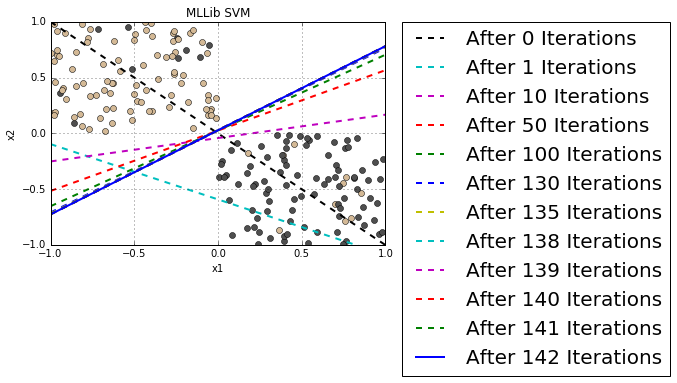

In [23]:
##### PLOTS FOR HW11.4 MLLIB SOFT SVM #####

%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.classification import SVMWithSGD
from pyspark.mllib.regression import LabeledPoint

# Parse the data
def parse_point(point):
    label = point[2]
    if label == -1:
        label = 0
    # A labeled point contains the label and an array of values as the features
    return LabeledPoint(label, point[0:2])

train_data = sc.parallelize(train_nonsep).map(parse_point)
test_data = sc.parallelize(test_nonsep).map(parse_point)

# Plot the data points, but don't display them yet
plot_data_no_show(train_nonsep, 'o', color_str_pos, color_str_neg, '')

# Set the initial weights and plot them
initial_weights = [1,1]
plot_weights_no_show([initial_weights[0], initial_weights[1], 0.0], 'k', '--', 0)

# Set the iterations
iterations = [1, 10, 50, 100, 130, 135, 138, 139, 140, 141, 142]
# Set the group of colors to be used
colors = ['c', 'm', 'r', 'g', 'b', 'y']
for i, num_iter in enumerate(iterations):
    print 'Iteration ', str(num_iter)
    # Build the model
    model = SVMWithSGD.train(train_data, iterations=num_iter, initialWeights=initial_weights, intercept=True)

    # Evaluating the model on testing data
    labelsAndPreds = test_data.map(lambda p: (p.label, model.predict(p.features)))
    testErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(test_data.count())
    print("Testing Error = " + str(testErr))

    # Set the shape of the line to '--' unless it's the last iteration in which case set it to a solid line.
    shape = '--'
    if num_iter == iterations[-1]:
        shape = '-'
    plot_weights_no_show([model.weights[0], model.weights[1], model.intercept], colors[i%len(colors)],
                         shape, num_iter)
    print 'Model Weights: ', [model.weights[0], model.weights[1], model.intercept]

# Display the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title('MLLib SVM')
plt.grid()
plt.show()

In [16]:
from collections import namedtuple
from math import sqrt
import numpy as np
Point = namedtuple('Point', 'x y')

#gradient descent (and with NO stochasticity!)
# Objective Function
# minw   λ/2   w’w   +   1/m Σi(1   –    yi(w’xi – b))+
# gradient 
#   λw               if      yi(w’xi – b))  > 1    #correctly classified
#   λw  + yi xi      Otherwise                    #incorrectly classified
#--------------------------------
#Wt+1  = wt + average(gradient)
#Wt+1  = wt + average(regularization + hinge loss)
#eta learning rate
def SVMGD(data, w=None, eta=0.01, iter_num=1000, regPara=0.01, stopCriteria=0.0001):
    featureLen = len(data.take(1)[0].x)
    n = data.count()
    if w==None:
        w = np.random.normal(size=featureLen)
    for i in range(iter_num):       #label * margin
        wBroadcast = sc.broadcast(w)
        sv = data.filter(lambda p: p.y*np.dot(wBroadcast.value, p.x)<1)  #Support vector? with label*margin<1
        if sv.isEmpty(): # converged as no more updates possible
            break       # hinge loss compoent of gradient y*x and sum up 
        g = -sv.map(lambda p: p.y*np.asarray(p.x)).reduce(lambda x,y: x + y) / n #gradient: avg hinge loss
        wreg = w*1   #temp copy of weight vector
        wreg[-1] = 0 #last value of weight vector is bias term; ignore in regularization
        wdelta = eta*(g+regPara*wreg)  #gradient: hinge loss + regularized term 
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)): # converged as updates to weight vector are small
            break
        w = w - wdelta
    return w

Initial Weights:  [0 0 0]
Iteration  1
Total Error:  1.76636538048
Model Weights:  [-0.88877928  0.8570361  -0.02055   ]
Iteration  2
Total Error:  0.0
Model Weights:  [-0.88877928  0.8570361  -0.02055   ]


/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


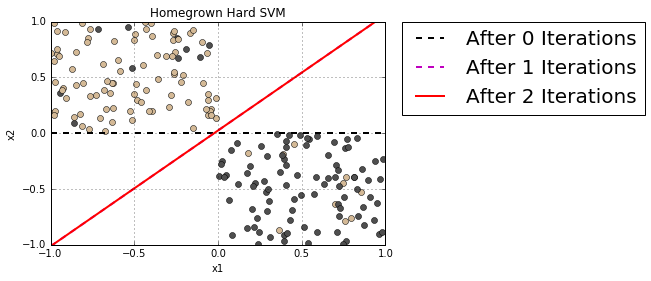

In [20]:
##### PLOTS FOR HW11.4 HOMEGROWN SVM #####

# Set a threshold for stopping criteria
epsilon = 1.0

# Plot the data points, but don't display them yet
plot_data_no_show(train_nonsep, 'o', color_str_pos, color_str_neg, '')

# Plot the initial weights
#w = np.array([1, 1, 0])
w = np.array([0, 0, 0])
print 'Initial Weights: ', w
plot_weights_no_show(w, 'k', '--', 0)

# Read the training data into Spark, weight it and cache it
data = sc.textFile('train_nonsep.csv').map(lambda x: readPoint(x, weighted=True)).cache()
n_train = data.count()

# Read the testing data into Spark, weight it and cache it
data_test = sc.textFile('test_nonsep.csv').map(lambda x: readPoint(x, weighted=True)).cache()
n_test = data_test.count()

# Set the colors to be used in the plots
colors = ['c', 'm', 'r', 'g', 'b', 'y']
i = 1
stop = False
while (stop == False):
    # Store the previous set of weights
    old_weights = w
    print 'Iteration ', str(i)
    # Run the logistic regression algorithm
    w = SVMGD(data, w)
    # Test to see if the stopping criterion is reached
    stop = stop_criterion_reached(old_weights, w, epsilon)
    # Set the shape of the line for the plot.  Set it to '--' unless it's the last iteration in which case
    # set it to a solid line
    shape = '--'
    if stop == True:
        shape = '-'
    # Plot the weights of this iteration
    plot_weights_no_show(w, colors[i%len(colors)], shape, i)
    print 'Model Weights: ', w
    i += 1

# Display the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title('Homegrown Hard SVM')
plt.grid()
plt.show()

<a name="HW11.5"><h2 style="color:darkgreen"> HW11.5  [OPTIONAL] Distributed Perceptron algorithm. </h2>
[Back to Table of Contents](#TOC)

Using the following papers as background:
http://static.googleusercontent.com/external_content/untrusted_dlcp/research.google.com/en//pubs/archive/36266.pdf

https://www.dropbox.com/s/a5pdcp0r8ptudgj/gesmundo-tomeh-eacl-2012.pdf?dl=0

http://www.slideshare.net/matsubaray/distributed-perceptron 

Implement each of the following flavors of perceptron learning algorithm:

1. Serial (All Data): This is the classifier returned if trained serially on all the available data.  On a single computer for example (Mistake driven)
2. Serial (Sub Sampling): Shard the data, select one shard randomly and train serially. 
3. Parallel (Parameter Mix): Learn a perceptron locally on each shard: 
Once learning is complete combine each learnt percepton using a uniform weighting
4. Parallel (Iterative Parameter Mix) as described in the above papers.

<a name="HW11.6"><h2 style="color:darkblue"> HW11.6 [OPTIONAL: consider doing this in a group]  Evalution of perceptron algorihtms on PennTreeBank POS corpus </h2>
[Back to Table of Contents](#TOC)

Reproduce the experiments reported in the following paper:

*Prediction with MapReduce - Andrea Gesmundo and  Nadi Tomeh*

http://www.aclweb.org/anthology/E12-2020 

These experiments focus on the prediction accuracy on a part-of-speech
(POS) task using the PennTreeBank corpus. They use sections 0-18 of the Wall
Street Journal for training, and sections 22-24 for testing.
 


<a name="HW11.7"><h2 style="color:darkgreen"> HW11.7 [OPTIONAL: consider doing this in a group] Kernal Adatron  </h2>
[Back to Table of Contents](#TOC)

Implement the Kernal Adatron in Spark (contact Jimi for details)


<a name="HW11.8"><h2 style="color:darkgreen"> HW11.8 [OPTIONAL] Create an animation of gradient descent for the Perceptron learning or for the logistic regression </h2>
[Back to Table of Contents](#TOC)
    
11.8 [OPTIONAL] Create an animation of gradient descent for the Perceptron learning or for the logistic regression learning with the following 3 training examples. Present the progress in terms of the 2 dimensional input space in terms of a contour plot and also in terms of the 3D surface plot. See Live slides for an example.

Here is a sample training dataset that can be used:
-2, 3, +1
-1, -1, -1
2, -3, 1

Please feel free to use 
 + R (yes R!)
 + d3
 + https://plot.ly/python/
 + Matplotlib

I am happy for folks to collaborate on HW11.8 also.

It would be great to get the 3D surface and contours lines (with solution region and label normalized data) all in the same graph

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HOWEWORK --------</h2></div></center>